In [1]:
# Cell 1
import gc
import numpy as np
import pandas as pd

import lightgbm as lgb

/home/coder/ICTProject/.venv/lib/python3.11/site-packages/distributed/diagnostics/rmm.py:8: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
  import rmm
/home/coder/ICTProject/.venv/lib/python3.11/site-packages/rmm/__init__.py:15: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
  from rmm import mr


In [ ]:
# Cell 2 – load features (load only needed columns)
FEATURE_PATH = '../data/outputs/features_for_classifier.parquet'
base_cols = ['customer_id','article_id','value','window_type_code']
meta_cols = [
    'customer_total_purchases','customer_unique_articles',
    'article_total_purchases','article_unique_customers',
    'cust_purchases_1w','cust_purchases_4w',
    'days_since_last_purchase','customer_days_since_last_purchase',
    'age','club_member_status','fashion_news_frequency','postal_code',
    'product_type_no','product_group_name','index_code','section_no',
    'graphical_appearance_no','colour_group_code','perceived_colour_value_id',
    'perceived_colour_master_id','index_group_no','garment_group_no',
    'article_mean_price','customer_mean_price'
]
read_cols = base_cols + meta_cols
data = pd.read_parquet(FEATURE_PATH, columns=read_cols)
print("Initial data shape:", data.shape)

# < 20gb of ram usage, 13 s

Initial data shape: (160523254, 28)


In [ ]:
# Cell 3 – build labels (filter early, drop tx ASAP)
tx = pd.read_csv(
    '../data/input_data/transactions_train.csv',
    usecols=['t_dat','customer_id','article_id'],
    dtype={'t_dat':'string','customer_id':'string','article_id':'int32'}
)
tx['customer_id'] = tx['customer_id'].str[-16:].apply(lambda h: np.int64(np.uint64(int(h,16))))
tx['t_dat'] = pd.to_datetime(tx['t_dat'])
last_ts = tx['t_dat'].max()
cut_ts  = last_ts - pd.Timedelta(days=7)

label_tx = tx[(tx['t_dat'] > cut_ts) & (tx['t_dat'] <= last_ts)][['customer_id','article_id']]
del tx
gc.collect()

labels = (label_tx
          .drop_duplicates()
          .assign(label=1)
)
del label_tx
gc.collect()

# ~ 20gb of ram usage, 2 min 17s

0

In [ ]:
# Cell 4 – merge + shrink (reuse read_cols)
data = data.merge(labels, on=['customer_id','article_id'], how='left')
data['label'] = data['label'].fillna(0).astype('int8')
feature_cols = read_cols  # already defined
# Downcasts (only if not already float32/int16/int32)
for col in feature_cols:
    if data[col].dtype == 'int64' and col not in ['customer_id']:
        data[col] = data[col].astype('int32')
num_fp32 = [
    'value','customer_total_purchases','customer_unique_articles',
    'article_total_purchases','article_unique_customers',
    'cust_purchases_1w','cust_purchases_4w',
    'days_since_last_purchase','customer_days_since_last_purchase',
    'age','article_mean_price','customer_mean_price'
]
for col in num_fp32:
    data[col] = data[col].astype('float32')
small_int16 = ['window_type_code','club_member_status','fashion_news_frequency',
               'product_group_name','index_code']
for col in small_int16:
    data[col] = data[col].astype('int16')

# ~ 30gb of ram usage, 1 min 33s

In [ ]:
# Cell 5 – label coverage (optional; if not needed, remove to save memory)
lab = labels[['customer_id','article_id']]
cand_pairs = data[['customer_id','article_id']]
covered = lab.merge(cand_pairs, on=['customer_id','article_id'], how='inner').shape[0]
print("Label pairs:", len(lab), "Covered:", covered,
      "Recall:", covered/len(lab))
del labels, lab, cand_pairs, covered
gc.collect()

# ~ 32gb of ram usage, 1 min 0s

Label pairs: 213728 Covered: 31312 Recall: 0.14650396765982932


0

In [ ]:
# Cell 6 – split + negative sampling (no group arrays)
rng = np.random.RandomState(42)
unique_customers = data['customer_id'].unique()
rng.shuffle(unique_customers)
cut = int(0.8 * len(unique_customers))
train_customers = set(unique_customers[:cut])
valid_customers = set(unique_customers[cut:])

train_mask = data['customer_id'].isin(train_customers)
valid_mask = ~train_mask  # complement

label_arr = data['label'].values
pos_idx = np.flatnonzero(train_mask.values & (label_arr == 1))
neg_idx = np.flatnonzero(train_mask.values & (label_arr == 0))

N_NEG_SAMPLE = 2_000_000
if len(neg_idx) > N_NEG_SAMPLE:
    neg_idx = rng.choice(neg_idx, size=N_NEG_SAMPLE, replace=False)

train_idx = np.concatenate([pos_idx, neg_idx])
valid_idx = np.flatnonzero(valid_mask.values)

train_data = data.iloc[train_idx]
valid_data = data.iloc[valid_idx]

X_train = train_data[feature_cols].to_numpy(dtype='float32')
y_train = train_data['label'].to_numpy()
X_valid = valid_data[feature_cols].to_numpy(dtype='float32')
y_valid = valid_data['label'].to_numpy()

del train_mask, valid_mask, label_arr, pos_idx, neg_idx, train_idx, valid_idx
gc.collect()

# ~ 25gb of ram usage, 25s

0

In [ ]:
# cell 7
tmp_users = data[['customer_id', 'cust_purchases_4w', 'customer_total_purchases']].drop_duplicates('customer_id')
print("Users with any history:", (tmp_users['customer_total_purchases'] > 0).sum())
print("Users with 0 history but some recent:",
      ((tmp_users['customer_total_purchases'] == 0) & (tmp_users['cust_purchases_4w'] > 0)).sum())
print("Users with history but no recent activity:",
      ((tmp_users['customer_total_purchases'] > 0) & (tmp_users['cust_purchases_4w'] == 0)).sum())

del tmp_users
gc.collect()

del data
gc.collect()

# ~ 27gb of ram usage, 5s

Users with any history: 1356709
Users with 0 history but some recent: 0
Users with history but no recent activity: 1121432


0

In [ ]:
# Cell 8 – train classifier (drop unused group vars)
clf_params = {
    'objective':'binary',
    'metric':'auc',
    'learning_rate':0.05,
    'num_leaves':64,
    'min_data_in_leaf':20,
    'feature_fraction':0.8,
    'n_estimators':200,
}
clf = lgb.LGBMClassifier(**clf_params, verbose=10, n_jobs=-1)
eval_results_clf = {}
clf.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[
        lgb.record_evaluation(eval_results_clf),
        lgb.early_stopping(stopping_rounds=20, verbose=False),
    ],
)
del X_train, y_train, X_valid, y_valid, train_data, valid_data
gc.collect()

# ~ 12gb of ram usage, 13 min 5s

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 25000, number of negative: 2000000
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.837866
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.157715
[LightGBM] [Debug] init for col-wise cost 0.051399 seconds, init for row-wise cost 0.285515 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.075253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

464

In [ ]:
# Score all candidates in batches to avoid copying the full data
if 'data' not in locals() or data is None:
    # feature_cols already contains 'customer_id' and 'article_id'
    cols_for_scoring = list(dict.fromkeys(feature_cols))  # de-dup, keep order
    data = pd.read_parquet(FEATURE_PATH, columns=cols_for_scoring)

# Ensure no duplicate column names slipped in
data = data.loc[:, ~data.columns.duplicated(keep='first')]

BATCH_SIZE = 5_000_000
n_rows = len(data)
scores = np.empty(n_rows, dtype=np.float32)

# Optional: sanity check on feature count
assert len(feature_cols) == clf.n_features_in_, f"Model expects {clf.n_features_in_}, feature_cols has {len(feature_cols)}"

print(f"Scoring {n_rows} rows...")
for start in range(0, n_rows, BATCH_SIZE):
    end = min(start + BATCH_SIZE, n_rows)
    X_batch = data.iloc[start:end][feature_cols].to_numpy(dtype='float32')
    scores[start:end] = clf.predict_proba(X_batch, raw_score=False)[:, 1].astype(np.float32)
    del X_batch
    gc.collect()

all_data_clf = data[['customer_id','article_id']].copy()
all_data_clf['score'] = scores
del scores, data
gc.collect()

# ~ 21gb of ram usage, 6 min 5s

Scoring 160523254 rows...


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


/home/coder/ICTProject/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


0

In [10]:
print("all_data_clf rows:", len(all_data_clf))
print("all_data_clf customers:", all_data_clf['customer_id'].nunique())

all_data_clf rows: 160523254
all_data_clf customers: 1371980


value                     1021
customer_mean_price       944
article_mean_price        888
customer_days_since_last_purchase 787
article_id                774
customer_id               742
postal_code               722
age                       719
customer_unique_articles  695
customer_total_purchases  666
article_total_purchases   569
days_since_last_purchase  448
article_unique_customers  414
garment_group_no          409
cust_purchases_4w         398
section_no                368
product_type_no           351
colour_group_code         274
window_type_code          222
graphical_appearance_no   205
cust_purchases_1w         202
product_group_name        188
perceived_colour_master_id 182
index_code                133
perceived_colour_value_id 113
fashion_news_frequency    94
club_member_status        55
index_group_no            17


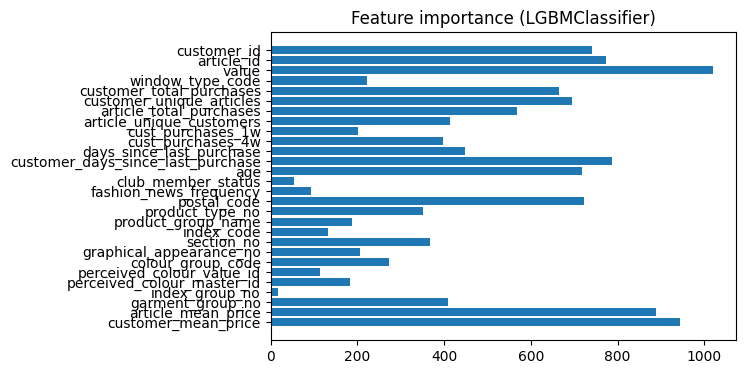

In [11]:
# cell 9
import matplotlib.pyplot as plt

importances = clf.feature_importances_
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"{name:25s} {imp}")

plt.figure(figsize=(6, 4))
plt.barh(feature_cols, importances)
plt.gca().invert_yaxis()
plt.title("Feature importance (LGBMClassifier)")
plt.show()

In [12]:
# cell 10
gc.collect()

6413

In [ ]:
# Cell 11 – build predictions per integer customer_id (no hex mapping here)
all_data_clf['article_id_str'] = '0' + all_data_clf['article_id'].astype(str)

BATCH_CUSTOMERS = 500_000
unique_cust = all_data_clf['customer_id'].unique()
pred_parts = []

for start in range(0, len(unique_cust), BATCH_CUSTOMERS):
    end = min(start + BATCH_CUSTOMERS, len(unique_cust))
    cust_chunk = unique_cust[start:end]
    chunk = all_data_clf[all_data_clf['customer_id'].isin(cust_chunk)].copy()
    chunk = chunk.sort_values(['customer_id', 'score'], ascending=[True, False])
    chunk = chunk.groupby('customer_id', group_keys=False).head(12)
    part = (
        chunk.groupby('customer_id')['article_id_str']
             .apply(lambda x: ' '.join(x))
             .reset_index()
             .rename(columns={'customer_id': 'customer_id_int',
                              'article_id_str': 'prediction'})
    )
    pred_parts.append(part)
    del chunk, part
    gc.collect()

pred_df_clf_int = pd.concat(pred_parts, ignore_index=True)
del pred_parts
gc.collect()

print("pred_df_clf_int rows:", len(pred_df_clf_int))
print("pred_df_clf_int customers:", pred_df_clf_int['customer_id_int'].nunique())

# Check how many items we actually recommend in total
pred_df_clf_int['n_items'] = pred_df_clf_int['prediction'].str.split().str.len()
print("Mean items per predicted customer:", pred_df_clf_int['n_items'].mean())
print("Min items per predicted customer:", pred_df_clf_int['n_items'].min())
print("Max items per predicted customer:", pred_df_clf_int['n_items'].max())
print("Total customer–item pairs:", pred_df_clf_int['n_items'].sum())
pred_df_clf_int.head()

del all_data_clf
gc.collect()

# ~ 20gb of ram usage, 5 min 53s

pred_df_clf_int rows: 1371980
pred_df_clf_int customers: 1371980
Mean items per predicted customer: 12.0
Min items per predicted customer: 12
Max items per predicted customer: 12
Total customer–item pairs: 16463760


15

In [14]:
# Cell 12 – attach hex ids and merge into sample_submission

# Load sample_submission and build integer key
sub = pd.read_csv(
    '../data/input_data/sample_submission.csv',
    usecols=['customer_id'],
    dtype={'customer_id': 'string'}
)
sub['customer_id_int'] = sub['customer_id'].str[-16:].apply(lambda h: np.int64(np.uint64(int(h, 16))))

print("sample_submission customers:", sub['customer_id_int'].nunique())
print("pred_df_clf_int customers:", pred_df_clf_int['customer_id_int'].nunique())

# Merge integer predictions onto submission customers
sub = sub.merge(
    pred_df_clf_int,
    how='left',
    on='customer_id_int'
)

print("rows in sub after merge:", len(sub))
print("rows with model preds (raw):", sub['prediction'].notna().sum())
print("rows needing fallback (raw):", sub['prediction'].isna().sum())

# Load global weekly trending list
gp = pd.read_json('../data/outputs/general_pred_str.json', typ='series')
general_pred_str = gp['general_pred_str']

# Fill gaps with the global list
sub['prediction'] = sub['prediction'].fillna(general_pred_str)
fallback_items = general_pred_str.split()

def pad_to_12(pred):
    items = pred.split()
    if len(items) >= 12:
        return ' '.join(items[:12])
    seen = set(items)
    for art in fallback_items:
        if art not in seen:
            items.append(art)
            seen.add(art)
        if len(items) == 12:
            break
    return ' '.join(items)

sub['prediction'] = sub['prediction'].apply(pad_to_12)

# Save submission using hex customer_id
sub[['customer_id', 'prediction']].to_csv(
    '../data/submission/lgbm_classifier_submission.csv',
    index=False
)

sub.head()

# ~ 25gb of ram usage, 25s

sample_submission customers: 1371980
pred_df_clf_int customers: 1371980
rows in sub after merge: 1371980
rows with model preds (raw): 1371980
rows needing fallback (raw): 0


,customer_id,customer_id_int,prediction,n_items
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327,0568601043 0858856005 0751471001 0568601006 09...,12
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310,0866731001 0909370001 0918292001 0448509014 09...,12
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936,0794321007 0805000001 0915526001 0794321011 09...,12
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410,0448509014 0751471001 0918292001 0751471043 07...,12
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310,0927530004 0918522001 0896152002 0818320001 07...,12
